# FKM Nonlinear example
The algorithm follows the document `"RICHTLINIE NICHTLINEAR / Rechnerischer Festigkeitsnachweis unter expliziter Erfassung nichtlinearen Werkstoffverformungsverhaltens / Für Bauteile aus Stahl, Stahlguss und Aluminiumknetlegierungen / 1.Auflage, 2019"`

#### Python module imports

In [1]:
# standard modules
import os
import pandas as pd
import numpy as np
import itertools
import timeit
import matplotlib.pyplot as plt
import matplotlib.patches
plt.rcParams.update({'font.size': 18})

# pylife
import pylife
import pylife.strength
import pylife.strength.fkm_nonlinear
import pylife.mesh.gradient

## Input data
#### Specify material and assessment parameters

In [2]:
assessment_parameters = pd.Series({
        'MatGroupFKM': 'Steel',  # [Steel, SteelCast, Al_wrought] material group
        'R_m': 600,              # [MPa] ultimate tensile strength (de: Zugfestigkeit)
        
        #'K_RP': 1,              # [-] surface roughness factor, set to 1 for polished surfaces or determine from the diagrams below
        'R_z': 250,              # [um] average roughness (de: mittlere Rauheit), only required if K_RP is not specified directly
    
        'c':   1.4,              # [MPa/N] (de: Übertragungsfaktor Vergleichsspannung zu Referenzlast im Nachweispunkt, c = sigma_I / L_REF)
        'A_sigma': 339.4,        # [mm^2] (de: Hochbeanspruchte Oberfläche des Bauteils)
        'A_ref': 500,            # [mm^2] (de: Hochbeanspruchte Oberfläche eines Referenzvolumens), usually set to 500
        'G': 0.15,               # [mm^-1] (de: bezogener Spannungsgradient)
        'K_p': 3.5,              # [-] (de: Traglastformzahl) K_p = F_plastic / F_yield (3.1.1)
    
        'P_A': 0.5,              # [-] failure probability (de: auszulegende Ausfallwahrscheinlichkeit), set to 0.5 to disable statistical assessment
        # beta: 0.5,             # damage index, specify this as an alternative to P_A
        'P_L': 50,               # [%] (one of 2.5%, 50%) (de: Auftretenswahrscheinlichkeit der Lastfolge), usually set to 50
        #'s_L': 10,              # [MPa] standard deviation of Gaussian distribution for load
        'n_bins': 200,           # optional (default: 200) number of bins or classes for P_RAJ computation. A larger value gives more accurate results but longer runtimes.
})

#### Specify load sequence

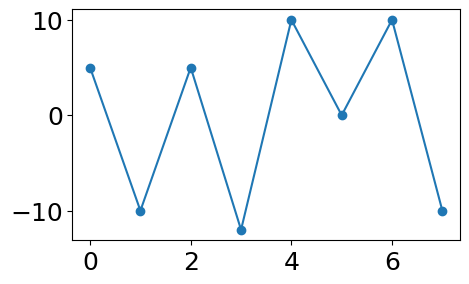

In [3]:
load_sequence = pd.Series([50, -100, 50, -120, 100, 0, 100, -100])*0.1  # [N]
fig = plt.figure(figsize=(5,3))
plt.plot(load_sequence, "o-")

#### Prepare the mesh
Here, we use a mesh in vmap format. Pylife can also handle Abaqus and Ansys files.
We load an example mesh ``../plate_with_hole.vmap``

In [4]:
# load mesh
linear_FE_filename = os.path.join("..","plate_with_hole.vmap")

# import the mesh using vmap
try:
    vmap_mesh = pylife.vmap.VMAPImport(linear_FE_filename)
except FileNotFoundError:
    vmap_mesh = pylife.vmap.VMAPImport(os.path.join("fkm_nonlinear",linear_FE_filename))
    
mesh = (vmap_mesh.make_mesh('1', 'STATE-2')
               .join_coordinates()
               .join_variable('STRESS_CAUCHY')
               .join_variable('DISPLACEMENT')
               .to_frame())
mesh['S_v'] = mesh.equistress.signed_mises_trace()

# Use the pylife Broadcaster to bring load sequence at each node of the mesh
# For details, see https://pylife.readthedocs.io/en/latest/general/signal.html#pylife.Broadcaster
parameter, object = pylife.Broadcaster(mesh['S_v']).broadcast(load_sequence)
mesh_load_sequence = parameter * object

# rename columns and create sorted DataFrame
mesh_load_sequence.index.rename(["element_id", "node_id", "load_step"], inplace=True)
mesh_load_sequence.name = "S_v"
mesh_load_sequence = pd.DataFrame(mesh_load_sequence)
mesh_load_sequence = mesh_load_sequence.sort_values(["element_id", "node_id"])
mesh_load_sequence.groupby("node_id").mean()

# reduce duplicate nodes
node_load_sequence = mesh_load_sequence.groupby(["node_id", "load_step"]).first()
n_nodes = node_load_sequence.groupby("load_step").count().iloc[0].squeeze()
print(f"n_nodes: {n_nodes}")

# reorder indices
reordered_load_sequence = node_load_sequence.reorder_levels(['load_step', 'node_id']).sort_index()
display(reordered_load_sequence)

d:\pylife\src\pylife\vmap\vmap_import.py:409: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for element_id, node_ids in connectivity.iteritems():
d:\pylife\src\pylife\vmap\vmap_import.py:409: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for element_id, node_ids in connectivity.iteritems():


n_nodes: 14614


S_v
load_step node_id             
0         1        -255.676040
          2         140.116532
          3         150.062177
          4         -58.491508
          5        1435.496109
...                        ...
7         14610    -566.775380
          14611    -218.950122
          14612    -497.112912
          14613    -385.977478
          14614    -451.518583

[116912 rows x 1 columns]

In [5]:
# compute gradient
tstart = timeit.default_timer()
#grad1 = mesh.gradient_3D.gradient_of('S_v')   # only for 3D meshes
grad1 = mesh[['dx', 'dy', 'dz']]
tend = timeit.default_timer()

print(f"Compute gradient duration: {tend-tstart:.1f} s")  # duration: 9.5 s

# compute the absolute stress gradient
grad1["abs_grad"] = np.linalg.norm(grad1, axis = 1)
mesh_load_sequence = mesh_load_sequence.join(grad1, sort=False)

# compute scaled stress gradient (bezogener Spannungsgradient)
mesh_load_sequence["G"] = mesh_load_sequence.abs_grad / mesh_load_sequence.S_v

# remove element_id
G = mesh_load_sequence['G'].droplevel(["element_id", "load_step"])

# remove duplicate node entries
G = G[~G.index.duplicated(keep="first")].sort_index()

assessment_parameters["G"] = G

Compute gradient duration: 0.0 s


C:\Users\mbe7rng\AppData\Local\Temp\ipykernel_5560\977381758.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad1["abs_grad"] = np.linalg.norm(grad1, axis = 1)


## Assessment with P_RAM
#### Run the FKM nonlinear algorithm

In [6]:
print("load sequence:")
display(reordered_load_sequence)

# all at once
t0 = timeit.default_timer()

result = pylife.strength.fkm_nonlinear.assessment_nonlinear_standard.perform_fkm_nonlinear_assessment(
    assessment_parameters, reordered_load_sequence, 
    calculate_P_RAM=True, calculate_P_RAJ=False)

t1 = timeit.default_timer()
print(f"P_RAM duration: {(t1-t0):.1f} s")

load sequence:


S_v
load_step node_id             
0         1        -255.676040
          2         140.116532
          3         150.062177
          4         -58.491508
          5        1435.496109
...                        ...
7         14610    -566.775380
          14611    -218.950122
          14612    -497.112912
          14613    -385.977478
          14614    -451.518583

[116912 rows x 1 columns]

d:\pylife\.venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


P_RAM duration: 2.0 s


In [7]:
print("\nP_RAM_is_life_infinite: \n", result["P_RAM_is_life_infinite"])
print("\nP_RAM_lifetime_n_cycles: \n", result["P_RAM_lifetime_n_cycles"])
print("\nP_RAM_lifetime_n_times_load_sequence: \n", result["P_RAM_lifetime_n_times_load_sequence"])


P_RAM_is_life_infinite: 
 assessment_point_index
0        False
1        False
2        False
3        False
4        False
         ...  
14609    False
14610    False
14611    False
14612    False
14613    False
Length: 14614, dtype: bool

P_RAM_lifetime_n_cycles: 
 [    0.         41729.91227646 25327.63671538 ...  2233.12054978
  8004.011386    3454.75578448]

P_RAM_lifetime_n_times_load_sequence: 
 [    0.         10432.47806911  6331.90917885 ...   558.28013745
  2001.0028465    863.68894612]


#### Visualize results for whole mesh

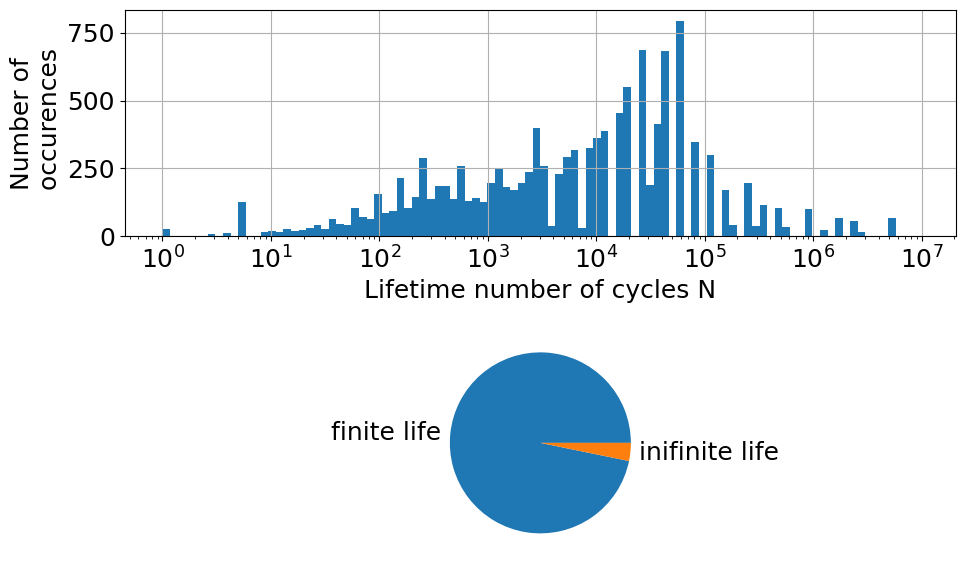

In [8]:
# create plots
fig, axes = plt.subplots(2,1,figsize=(10,6))

n_cycles = result["P_RAM_lifetime_n_cycles"]

# remove nans 
x = np.where(np.isinf(n_cycles) | (n_cycles==0) | (n_cycles>=1e7), np.nan, n_cycles)
x = [v for v in x if not np.isnan(v)]

# plot logarithmic
hist, bins = np.histogram(x, bins=100)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
axes[0].hist(x,bins=logbins)
axes[0].set_xscale('log')
axes[0].grid()
axes[0].set_ylabel("Number of\n occurences")
axes[0].set_xlabel("Lifetime number of cycles N")

n_life_infinite = result["P_RAM_is_life_infinite"].sum()
n_total = len(result["P_RAM_is_life_infinite"])
axes[1].pie([n_total-n_life_infinite, n_life_infinite], labels=["finite life",  "inifinite life"])
plt.tight_layout()

In [9]:
result["P_RAM_collective"]

loads_min    loads_max       S_min  \
hysteresis_index assessment_point_index                                         
0                0                       -357.946456   357.946456 -312.678359   
                 1                       -196.163145   196.163145 -226.792023   
                 2                       -210.087048   210.087048 -226.792023   
                 3                        -81.888111    81.888111  -96.313080   
                 4                      -2009.694553  2009.694553 -872.570598   
...                                              ...          ...         ...   
6                14609                      0.000000   793.485532 -191.924995   
                 14610                      0.000000   306.530171  -67.839209   
                 14611                      0.000000   695.958077 -186.411202   
                 14612                      0.000000   540.368469 -148.613384   
                 14613                      0.000000   632.126017 -175.293598   

                                              S_max         R  epsilon_min  \
hysteresis_index assessment_point_index                                      
0                0                       312.678359 -1.000000    -0.002325   
                 1                       226.792023 -1.000000    -0.001246   
                 2                       226.792023 -1.000000    -0.001246   
                 3                        96.313080 -1.000000    -0.000469   
                 4                       872.570598 -1.000000    -0.199331   
...                                             ...       ...          ...   
6                14609                   455.262062 -0.421570     0.002824   
                 14610                   264.231306 -0.256742    -0.000142   
                 14611                   415.598002 -0.448537     0.001038   
                 14612                   371.767523 -0.399748     0.000517   
                 14613                   401.616066 -0.436471     0.000962   

                                         epsilon_max         S_a         S_m  \
hysteresis_index assessment_point_index                                        
0                0                          0.002325  312.678359    0.000000   
                 1                          0.001246  226.792023    0.000000   
                 2                          0.001246  226.792023    0.000000   
                 3                          0.000469   96.313080    0.000000   
                 4                          0.199331  872.570598    0.000000   
...                                              ...         ...         ...   
6                14609                      0.007904  323.593528  131.668533   
                 14610                      0.001524  166.035257   98.196048   
                 14611                      0.005277  301.004602  114.593400   
                 14612                      0.003647  260.190454  111.577070   
                 14613                      0.004811  288.454832  113.161234   

                                         epsilon_a  ...  epsilon_min_LF  \
hysteresis_index assessment_point_index             ...                   
0                0                        0.002325  ...       -0.002325   
                 1                        0.001246  ...        0.000000   
                 2                        0.001246  ...        0.000000   
                 3                        0.000469  ...       -0.000469   
                 4                        0.199331  ...        0.000000   
...                                            ...  ...             ...   
6                14609                    0.002540  ...        0.000000   
                 14610                    0.000833  ...        0.000000   
                 14611                    0.002120  ...        0.000000   
                 14612                    0.001565  ...        0.000000   
                 14613           

#### Plot stress-strain curves

Text(0.5, 1.0, 'Material response for a fictive point with mean stress')

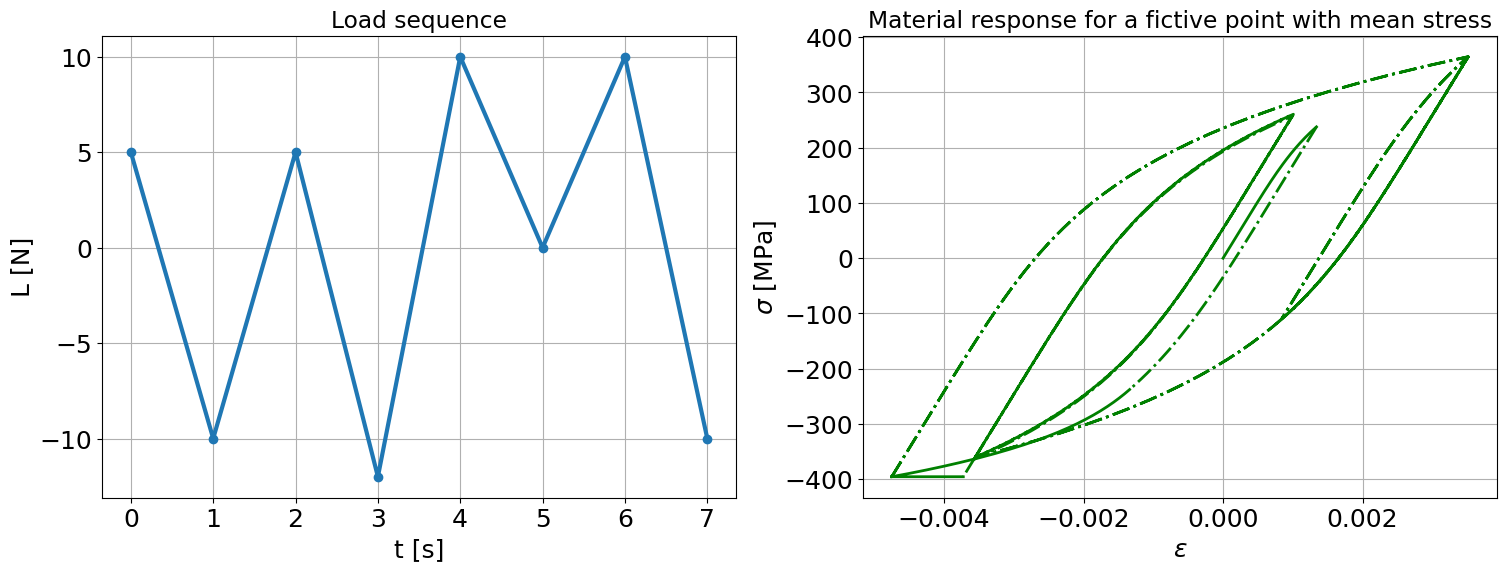

In [10]:
# plot resulting stress-strain curve
assessment_parameters_scalar = assessment_parameters
assessment_parameters_scalar.G = np.max(assessment_parameters_scalar.G)
scalar_load_sequence = pd.Series(reordered_load_sequence.groupby("load_step").mean().values.flatten())
result_scalar = pylife.strength.fkm_nonlinear.assessment_nonlinear_standard.perform_fkm_nonlinear_assessment(
    assessment_parameters_scalar, scalar_load_sequence, 
    calculate_P_RAM=True, calculate_P_RAJ=False)


detector = result_scalar['P_RAM_detector']

sampling_parameter = 50    # choose larger for smoother plot
strain_values_primary, stress_values_primary, hysteresis_index_primary, \
strain_values_secondary, stress_values_secondary, hysteresis_index_secondary \
    = detector.interpolated_stress_strain_data(sampling_parameter)

# all hystereses in stress-strain diagram
fig, axes = plt.subplots(1, 2, figsize=(18,6))
# load-time diagram
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
axes[0].plot(load_sequence, "o-", lw=3)
axes[0].grid()
axes[0].set_xlabel("t [s]")
axes[0].set_ylabel("L [N]")
axes[0].set_title("Load sequence")

# stress-strain diagram
axes[1].plot(strain_values_primary, stress_values_primary, "g-", lw=2)
axes[1].plot(strain_values_secondary, stress_values_secondary, "g-.", lw=2)
axes[1].grid()
axes[1].set_xlabel("$\epsilon$")
axes[1].set_ylabel("$\sigma$ [MPa]")
axes[1].set_title("Material response for a fictive point with mean stress")
    

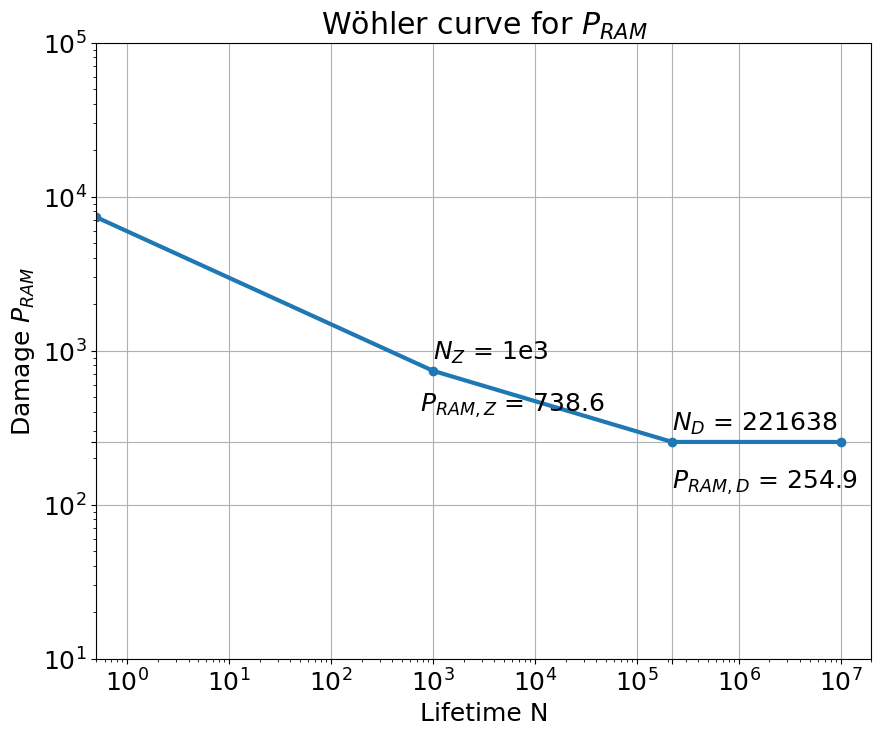

In [11]:
# draw Wöhler curve
woehler_curve_vectorized = result["P_RAM_woehler_curve"]
woehler_curve = woehler_curve_vectorized.get_woehler_curve_minimum_lifetime()

n_list = [5e-1, 1e3, woehler_curve.fatigue_life_limit, 1e7]

plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(figsize=(10,8))
plt.plot(n_list, woehler_curve.calc_P_RAM(n_list), "o-", lw=3)

# axes scaling
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lifetime N')
plt.ylabel('Damage $P_{RAM}$')

# add title
title = "Wöhler curve for $P_{RAM}$"
plt.title(title)

# add x tick at fatigue life limit
plt.xticks(list(plt.xticks()[0]) + [woehler_curve.fatigue_life_limit])

# annotate P_RAM_D
plt.annotate("$N_D$ = " + f"{woehler_curve.fatigue_life_limit:.0f}", 
             xy=(woehler_curve.fatigue_life_limit, woehler_curve.fatigue_strength_limit*1.2))
plt.annotate("$P_{RAM,D}$ = "+f"{woehler_curve.fatigue_strength_limit:.1f}", 
             xy=(woehler_curve.fatigue_life_limit, woehler_curve.fatigue_strength_limit*0.5))


# annotate P_RAM_D
plt.annotate("$N_Z$ = 1e3", 
             xy=(1e3, woehler_curve.calc_P_RAM(1e3)*1.2))
plt.annotate("$P_{RAM,Z}$ = "+f"{woehler_curve.P_RAM_Z:.1f}", 
             xy=(woehler_curve.P_RAM_Z, woehler_curve.calc_P_RAM(woehler_curve.P_RAM_Z)*0.5))
plt.xlim(5e-1, 2e7)

# add y tick at fatigue strength limit
plt.yticks(list(plt.yticks()[0]) + [woehler_curve.fatigue_strength_limit])

plt.show()

## Assessment with P_RAJ
#### Run the FKM nonlinear algorithm

In [12]:
print("load sequence:")
display(reordered_load_sequence)

# perform assessment for all points in the mesh at once
t0 = timeit.default_timer()

result = pylife.strength.fkm_nonlinear.assessment_nonlinear_standard.perform_fkm_nonlinear_assessment(
    assessment_parameters, reordered_load_sequence, 
    calculate_P_RAM=False, calculate_P_RAJ=True)

t1 = timeit.default_timer()
print(f"P_RAJ duration: {(t1-t0):.1f} s")

load sequence:


S_v
load_step node_id             
0         1        -255.676040
          2         140.116532
          3         150.062177
          4         -58.491508
          5        1435.496109
...                        ...
7         14610    -566.775380
          14611    -218.950122
          14612    -497.112912
          14613    -385.977478
          14614    -451.518583

[116912 rows x 1 columns]

P_RAJ duration: 34.9 s


In [13]:
np.set_printoptions(edgeitems=5, linewidth=120)
print("\nP_RAJ_is_life_infinite: \n", result["P_RAJ_is_life_infinite"])
print("\nP_RAJ_lifetime_n_cycles: \n", result["P_RAJ_lifetime_n_cycles"])
print("\nP_RAJ_lifetime_n_times_load_sequence: \n", result["P_RAJ_lifetime_n_times_load_sequence"])


P_RAJ_is_life_infinite: 
 assessment_point_index
0        False
1        False
2        False
3         True
4        False
         ...  
14609    False
14610    False
14611    False
14612    False
14613    False
Name: P_RAJ, Length: 14614, dtype: bool

P_RAJ_lifetime_n_cycles: 
 [2.89960317e+03 7.08381094e+04 4.37867364e+04            inf 2.00000000e+00 ... 1.63070503e+03 3.19080976e+05
 3.69359537e+03 1.37689927e+04 6.56966338e+03]

P_RAJ_lifetime_n_times_load_sequence: 
 [  724.90079248 17709.52734317 10946.684096              inf     0.         ...   407.67625861 79770.24408307
   923.39884352  3442.24818038  1642.41584498]


#### Visualize results for whole mesh

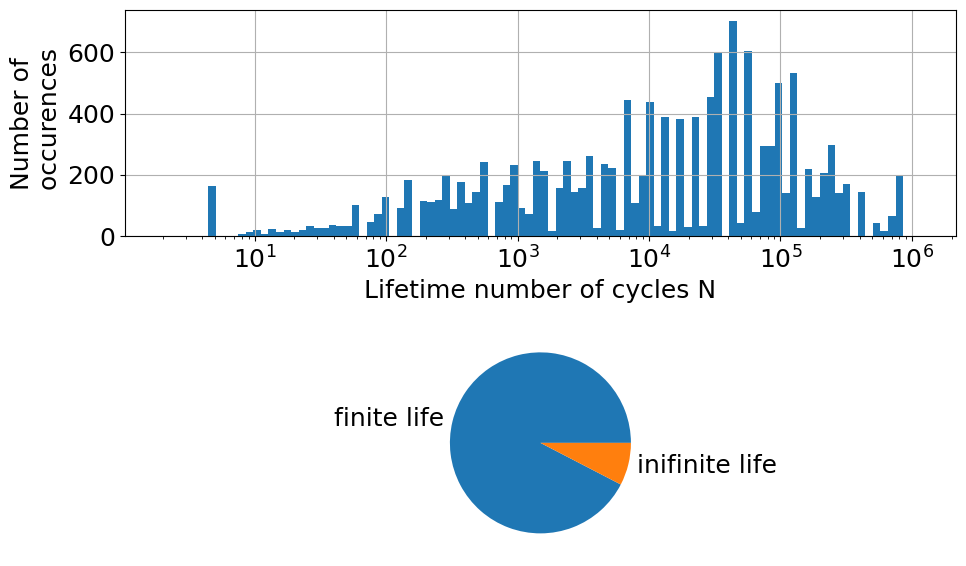

In [14]:
# create plots
fig, axes = plt.subplots(2,1,figsize=(10,6))

n_cycles = result["P_RAJ_lifetime_n_cycles"]

# remove nans 
x = np.where(np.isinf(n_cycles) | (n_cycles==0) | (n_cycles>=1e7), np.nan, n_cycles)
x = [v for v in x if not np.isnan(v)]

# plot logarithmic
hist, bins = np.histogram(x, bins=100)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
axes[0].hist(x,bins=logbins)
axes[0].set_xscale('log')
axes[0].grid()
axes[0].set_ylabel("Number of\n occurences")
axes[0].set_xlabel("Lifetime number of cycles N")

n_life_infinite = result["P_RAJ_is_life_infinite"].sum()
n_total = len(result["P_RAJ_is_life_infinite"])
axes[1].pie([n_total-n_life_infinite, n_life_infinite], labels=["finite life",  "inifinite life"])
plt.tight_layout()

#### Plot woehler curve

woehler_curve.fatigue_life_limit: 317588
                           final: 27018580338 (+8507334.60 %)


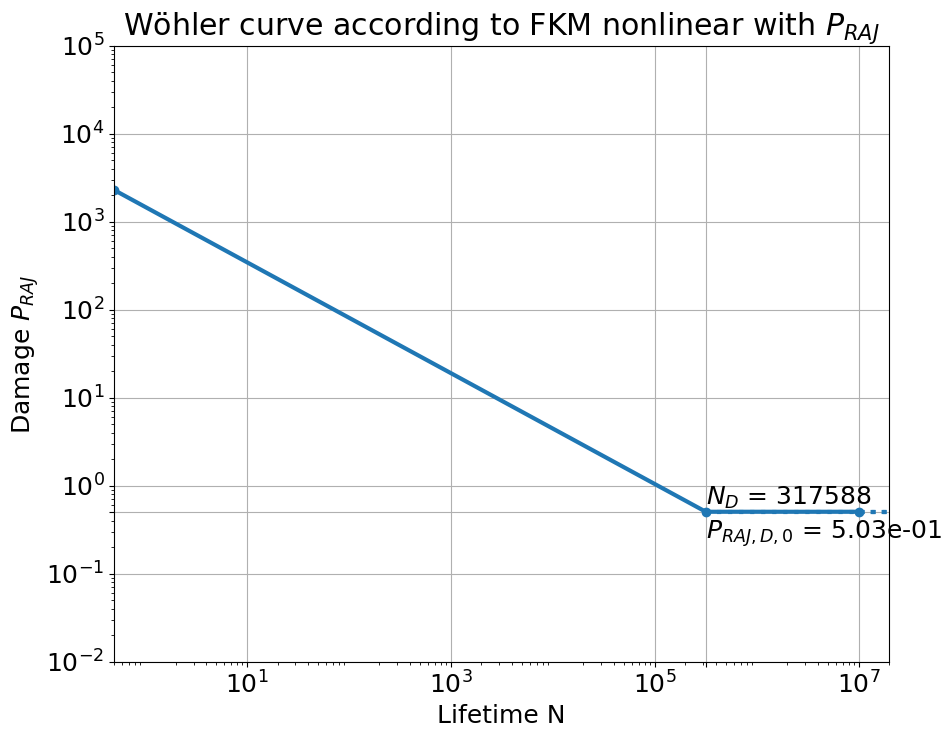

In [15]:
# draw Wöhler curve
woehler_curve_vectorized = result["P_RAJ_woehler_curve"]
woehler_curve = woehler_curve_vectorized.get_woehler_curve_minimum_lifetime()

n_list = [5e-1, woehler_curve.fatigue_life_limit, 1e7]

print(f"woehler_curve.fatigue_life_limit: {woehler_curve.fatigue_life_limit:.0f}")
print(f"                           final: {woehler_curve.fatigue_life_limit_final.max():.0f}" \
  f" ({100*woehler_curve.fatigue_life_limit_final.max()/woehler_curve.fatigue_life_limit-100:+.2f} %)")

plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(figsize=(10,8))

# initial Wöhler curve
line, = plt.plot(n_list, woehler_curve.calc_P_RAJ(n_list), "o-", lw=3)

# Wöhler curve at end of assessment
n_list = [woehler_curve.fatigue_life_limit, woehler_curve.fatigue_life_limit_final.max(), 1e7]
p_list = [woehler_curve.fatigue_strength_limit, woehler_curve.fatigue_strength_limit_final.max(), 
          woehler_curve.fatigue_strength_limit_final.max()]
plt.plot(n_list, p_list, ":", lw=3, c=line.get_color())


# axes scaling
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lifetime N')
plt.ylabel('Damage $P_{RAJ}$')

# add title
title = "Wöhler curve according to FKM nonlinear with $P_{RAJ}$"
plt.title(title)

# add x tick at fatigue life limit
plt.xticks(list(plt.xticks()[0]) + [woehler_curve.fatigue_life_limit])

# annotate P_RAJ_D
plt.annotate("$N_D$ = " + f"{woehler_curve.fatigue_life_limit:.0f}", 
             xy=(woehler_curve.fatigue_life_limit, woehler_curve.fatigue_strength_limit*1.2))
plt.annotate("$P_{RAJ,D,0}$ = "+f"{woehler_curve.fatigue_strength_limit:.2e}", 
             xy=(woehler_curve.fatigue_life_limit, woehler_curve.fatigue_strength_limit*0.5))
plt.xlim(5e-1, 2e7)

# add y tick at fatigue strength limit
plt.yticks(list(plt.yticks()[0]) + [woehler_curve.fatigue_strength_limit])

plt.show()